In [24]:
# =============================================================
# VISUALIZACIÓN DE LISTA ENLAZADA DE PEDIDOS
# =============================================================

import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import mysql.connector
from lst import ListaEnlazadaPedidos

load_dotenv()

True

In [51]:
# Crear lista enlazada y conexión a BD
lista_pedidos = ListaEnlazadaPedidos()

mydb = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME")
)
cursor = mydb.cursor(dictionary=True)

# Obtener pedidos con sus productos
cursor.execute("SELECT * FROM pedidos")
pedidos = cursor.fetchall()

for ped in pedidos:
    # Obtener productos de cada pedido
    cursor.execute("""
        SELECT pp.producto_id, p.nombre, p.precio, pp.cantidad
        FROM pedido_productos pp
        JOIN productos p ON p.producto_id = pp.producto_id
        WHERE pp.pedido_id = %s
    """, (ped["pedido_id"],))
    productos = cursor.fetchall()
    
    # Agregar pedido a la lista enlazada
    lista_pedidos.agregar_pedido(
        ped["pedido_id"],
        ped["cliente"],
        ped["fecha_pedido"].isoformat() if hasattr(ped["fecha_pedido"], 'isoformat') else str(ped["fecha_pedido"]),
        [{"producto_id": p["producto_id"], "nombre": p["nombre"], 
          "precio": float(p["precio"]), "cantidad": p["cantidad"]} for p in productos]
    )

cursor.close()
mydb.close()

# Mostrar pedidos cargados
print(f"Se cargaron {len(lista_pedidos.listar_pedidos())} pedidos:\n")
for p in lista_pedidos.listar_pedidos():
    print(f"  Pedido #{p['pedido_id']} - Cliente: {p['cliente']} - Productos: {len(p['productos'])}")

Se cargaron 2 pedidos:

  Pedido #1 - Cliente: Maria Jose Santos - Productos: 2
  Pedido #2 - Cliente: Elsy Edelmira Chevez - Productos: 2


In [26]:
class SimpleHashTable:
    def __init__(self, size):
        self.size = size
        self.table = [[] for _ in range(size)]

    def _hash(self, key):
        return key % self.size  # hash simple para visualizar colisiones

    def insert(self, key, value):
        idx = self._hash(key)
        for i, (k, v) in enumerate(self.table[idx]):
            if k == key:
                self.table[idx][i] = (key, value)
                return
        self.table[idx].append((key, value))

    def get(self, key):
        idx = self._hash(key)
        for k, v in self.table[idx]:
            if k == key:
                print(f"¡Clave {key} encontrada! Valor: {v}")
                return v
        print(f"Clave {key} NO encontrada.")
        return None

In [52]:
#Lista enlazada con Hash Table
hash_table = SimpleHashTable(size=10)
for pedido in lista_pedidos.listar_pedidos():
    hash_table.insert(pedido['pedido_id'], pedido)
# Ejemplo de búsqueda
hash_table.get(2)

lista_pedidos = ListaEnlazadaPedidos()
mydb = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME")
)
cursor = mydb.cursor(dictionary=True)
cursor.execute("SELECT * FROM pedidos")
pedidos = cursor.fetchall()
for ped in pedidos:
    cursor.execute("""
        SELECT pp.producto_id, p.nombre, p.precio, pp.cantidad
        FROM pedido_productos pp
        JOIN productos p ON p.producto_id = pp.producto_id
        WHERE pp.pedido_id = %s
    """, (ped["pedido_id"],))
    productos = cursor.fetchall()
    lista_pedidos.agregar_pedido(
        ped["pedido_id"],
        ped["cliente"],
        ped["fecha_pedido"].isoformat() if hasattr(ped["fecha_pedido"], 'isoformat') else str(ped["fecha_pedido"]),
        [{"producto_id": p["producto_id"], "nombre": p["nombre"], 
          "precio": float(p["precio"]), "cantidad": p["cantidad"]} for p in productos]
    )
cursor.close()
mydb.close()

¡Clave 2 encontrada! Valor: {'pedido_id': 2, 'cliente': 'Elsy Edelmira Chevez', 'fecha': '2025-12-10T00:00:00', 'productos': [{'producto_id': 1, 'nombre': 'Teclado Mecanico', 'precio': 1685.45, 'cantidad': 8}, {'producto_id': 2, 'nombre': 'Mouse', 'precio': 700.0, 'cantidad': 2}]}


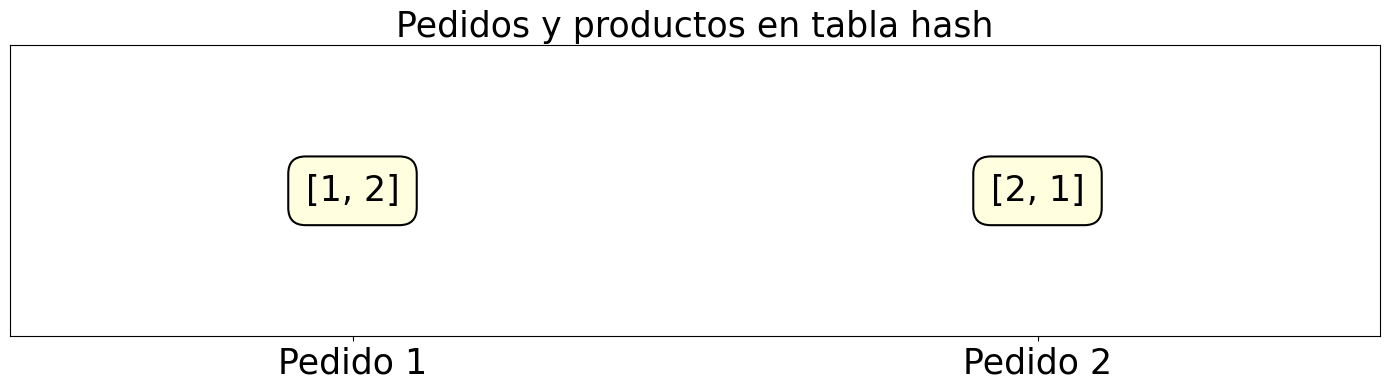

In [45]:
# Visualizacion de tabla hash: Pedidos como indices, productos como valores
pedidos_lista = lista_pedidos.listar_pedidos()

# Crear una tabla hash donde la clave es el pedido_id y el valor son los producto_ids
hash_pedidos_productos = SimpleHashTable(size=len(pedidos_lista))
for pedido in pedidos_lista:
    productos_ids = [p['producto_id'] for p in pedido['productos']]
    hash_pedidos_productos.insert(pedido['pedido_id'], productos_ids)

fig, ax = plt.subplots(figsize=(14, 4))

for i, bucket in enumerate(hash_pedidos_productos.table):
    if bucket:
        # Obtener los productos de este bucket
        productos = [v for k, v in bucket]
        # Aplanar la lista de productos
        todos_productos = []
        for lista_prod in productos:
            todos_productos.extend(lista_prod)
        texto = str(todos_productos) if todos_productos else "[]"
    else:
        texto = "[]"
    
    ax.text(i, 0.5, texto, ha='center', va='center', fontsize=25, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='black', linewidth=1.5))

ax.set_xticks(range(len(hash_pedidos_productos.table)))
ax.set_xticklabels([f'Pedido {pedidos_lista[i]["pedido_id"]}' if i < len(pedidos_lista) else f'Indice {i}' 
                    for i in range(len(hash_pedidos_productos.table))], fontsize=25)
ax.set_yticks([])
ax.set_xlim(-0.5, len(hash_pedidos_productos.table) - 0.5)
plt.ylim(-0.5, 1.5)
plt.title("Pedidos y productos en tabla hash", fontsize=25)
plt.tight_layout()
plt.show()